## 1. EDA bộ dataset

- Hiển thị được phân phối class của tập train/test
- Thông kê được tổng số dữ liệu, tổng số class

In [1]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import torch.optim as optim
from glob import glob
from tqdm import tqdm
import random
from torch.utils.data import DataLoader

In [2]:
# Chuẩn bị transform
# Chuẩn bị transform
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Tải dữ liệu
train_data = torchvision.datasets.ImageFolder(root='dataset/train', transform=train_transforms)
test_data = torchvision.datasets.ImageFolder(root='dataset/test', transform=test_transforms)
# Số lượng các lớp
num_classes = len(train_data.classes)
# Tên của các lớp
classes_name = train_data.classes
# classes2idx: ánh xạ từ tên lớp sang chỉ số (index)
classes2idx = train_data.class_to_idx
print(f"Số lượng lớp: {num_classes}")
print(f"Tên lớp: {classes_name}")
print(f"Ánh xạ từ tên lớp sang chỉ số: {classes2idx}")
print("Number of train: ", len(train_data))
print("Number of test: ", len(test_data))


Số lượng lớp: 6
Tên lớp: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Ánh xạ từ tên lớp sang chỉ số: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Number of train:  14034
Number of test:  3115


In [3]:
train_data

Dataset ImageFolder
    Number of datapoints: 14034
    Root location: dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

run: 100%|██████████| 6/6 [00:00<00:00, 122.43it/s]


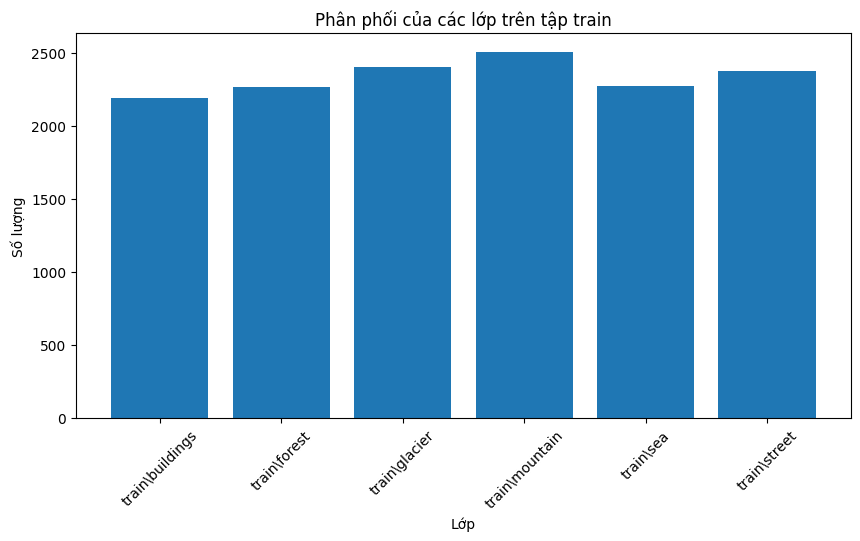

In [4]:
# Phân phối của các lớp trên tập train
all_class = glob("dataset/train/*")
train_class_counts =  {}
for folder_class in tqdm(all_class, desc='run'):
    name = folder_class.split('/')[-1]
    train_class_counts[name] = len(glob(f"{folder_class}/*"))
train_class_counts = dict(sorted(train_class_counts.items(), key=lambda item: item[0]))

plt.figure(figsize=(10, 5))
plt.bar(list(train_class_counts.keys()), list(train_class_counts.values()))
plt.title('Phân phối của các lớp trên tập train')
plt.xlabel('Lớp')
plt.ylabel('Số lượng')
plt.xticks(rotation=45)
plt.show()

run: 100%|██████████| 6/6 [00:00<00:00, 545.41it/s]


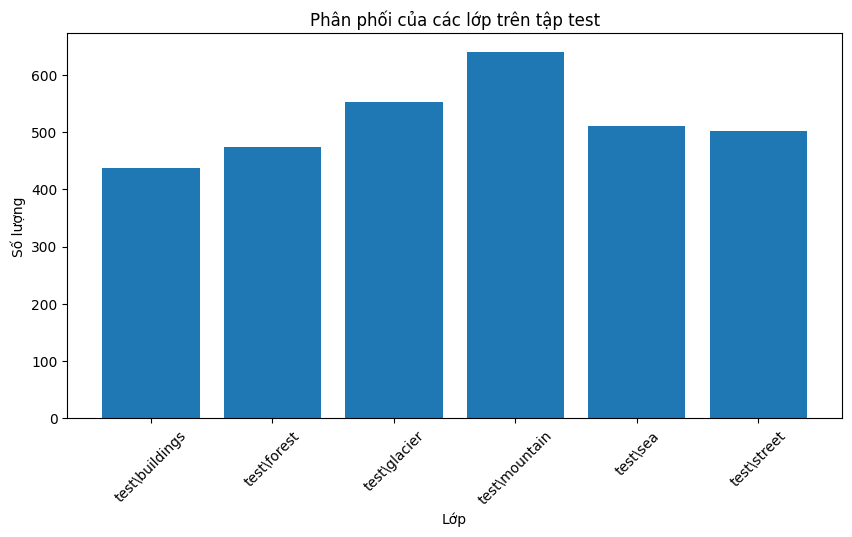

In [5]:
# Phân phối của các lớp trên tập test
all_test_classes = glob("dataset/test/*")
test_class_counts = {}
for folder_class in tqdm(all_test_classes, desc='run'):
    name = folder_class.split('/')[-1]
    test_class_counts[name] = len(glob(f"{folder_class}/*"))

# Sort dict by key
test_class_counts = dict(sorted(test_class_counts.items(), key=lambda item: item[0]))

# Hiển thị đồ thị phân phối tập test
plt.figure(figsize=(10, 5))
plt.bar(list(test_class_counts.keys()), list(test_class_counts.values()))
plt.title('Phân phối của các lớp trên tập test')
plt.xlabel('Lớp')
plt.ylabel('Số lượng')
plt.xticks(rotation=45)
plt.show()

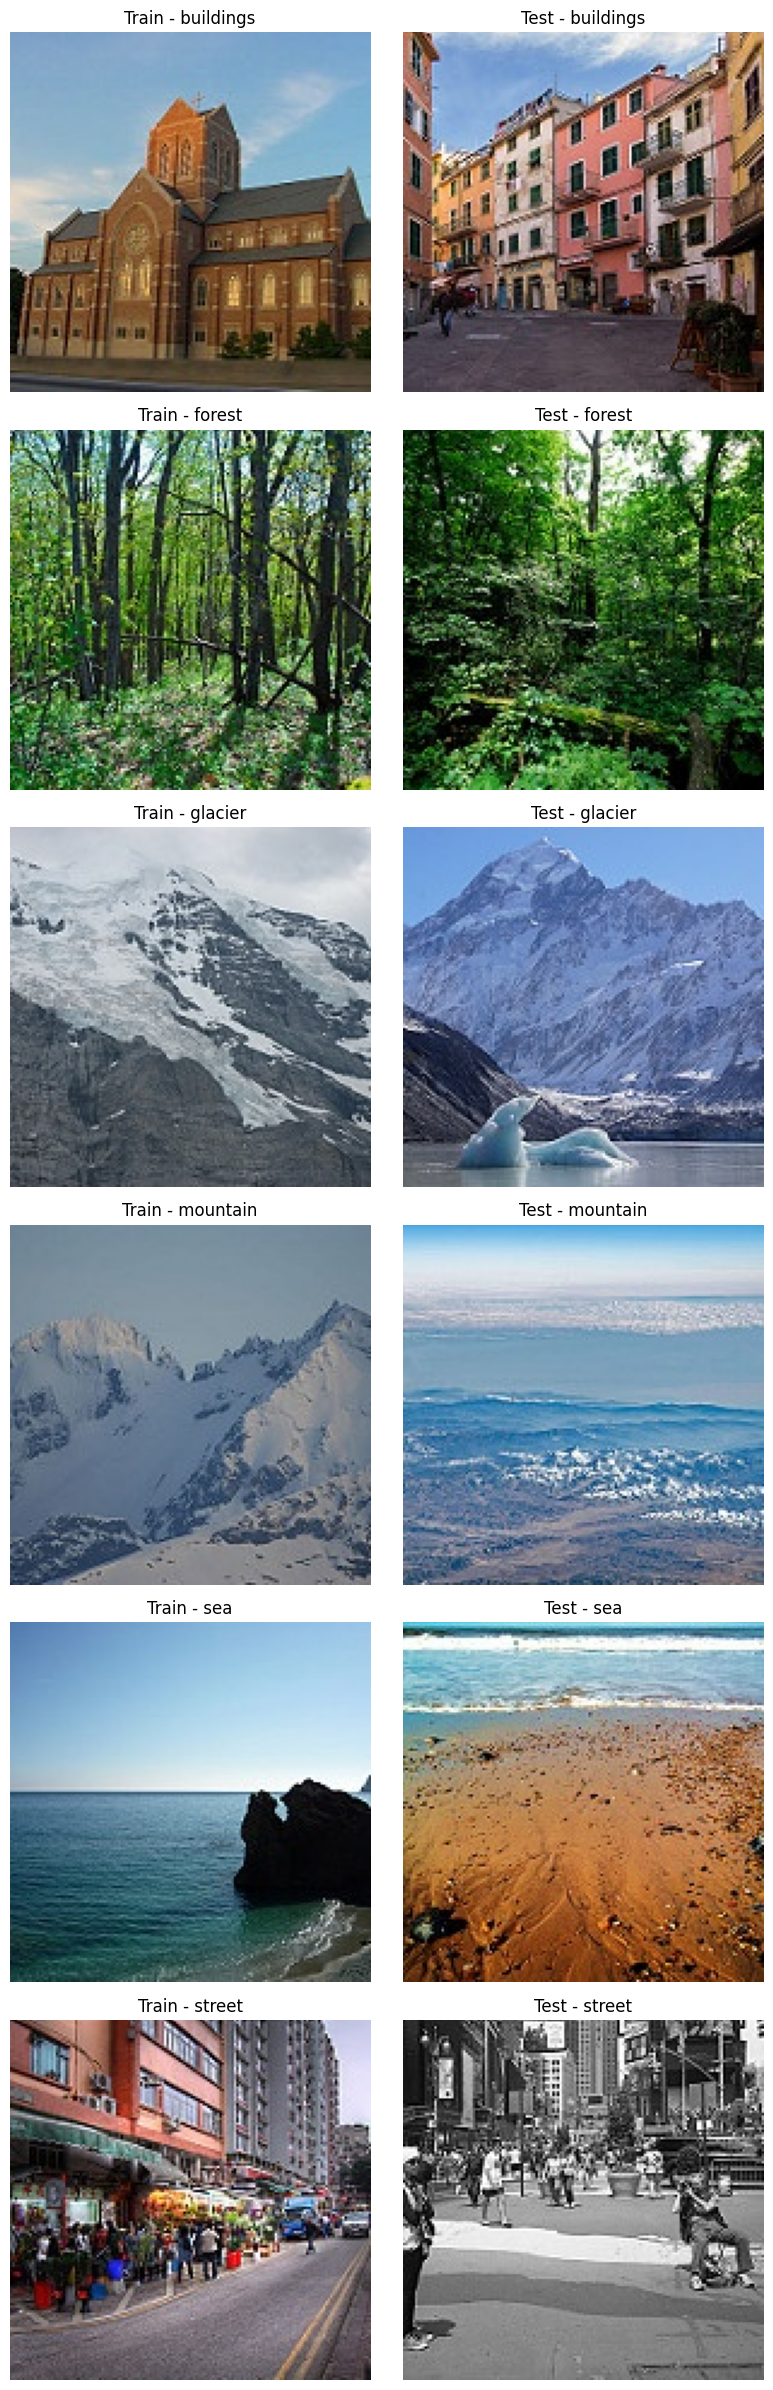

In [6]:
# Khởi tạo kích thước của figure
num_rows = len(classes_name)
num_cols = 3
plt.figure(figsize=(num_cols * 4, num_rows * 4))

# Vòng lặp để vẽ hình
for idx, c in enumerate(classes_name, start=1):
    # Lấy ngẫu nhiên một hình từ thư mục train và test
    path_test_image = random.choice(list(glob(f"dataset/test/{c}/*")))
    path_train_image = random.choice(list(glob(f"dataset/train/{c}/*")))

    # Thêm subplot cho cặp hình
    plt.subplot(num_rows, num_cols, idx * num_cols - 2)
    plt.imshow(plt.imread(path_train_image))
    plt.title(f"Train - {c}")
    plt.axis("off")

    plt.subplot(num_rows, num_cols, idx * num_cols - 1)
    plt.imshow(plt.imread(path_test_image))
    plt.title(f"Test - {c}")
    plt.axis("off")

# Hiển thị đồ thị
plt.tight_layout()
plt.show()




## 2. Modeling

In [7]:
import torch
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn

#### Define models CNNs basic

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes = 10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool1 = nn.MaxPool2d(2, 2)  # Max pooling layer 1
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.pool2 = nn.MaxPool2d(2, 2)  # Max pooling layer 2
        self.fc1 = nn.Linear(32*62*62, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x

In [9]:
## Kiểm tra tính hoạt động của mạng custom này
import torch
model = SimpleCNN()
random_image = torch.rand(1, 3, 256, 256)
model(random_image).shape

torch.Size([1, 10])

In [10]:
import torch
model = SimpleCNN()
random_image = torch.rand(1, 3, 448, 448)
model(random_image).shape

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x387200 and 123008x256)

### => Error do việc fix cứng 32x62x62

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes = 10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool1 = nn.MaxPool2d(2, 2)  # Max pooling layer 1
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.pool2 = nn.MaxPool2d(2, 2)  # Max pooling layer 2
        self.conv3 = nn.Conv2d(32, 32, 3)
        self.pool3 = nn.MaxPool2d(2, 2)  # Max pooling layer 2
        self.avgpool = nn.AdaptiveAvgPool2d((16, 16))
        self.fc1 = nn.Linear(32*16*16, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.batch_norm1 = nn.BatchNorm2d(16)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.batch_norm3 = nn.BatchNorm2d(32)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.batch_norm1(x)  # Apply batch normalization
        x = self.pool1(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.batch_norm2(x)  # Apply batch normalization
        x = self.pool2(x)
        x = self.conv3(x)
        x = nn.functional.relu(x)
        x = self.batch_norm3(x)  # Apply batch normalization
        x = self.pool3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x

In [12]:
## Kiểm tra tính hoạt động của mạng custom này
import torch
model = SimpleCNN()
random_image = torch.rand(1, 3, 256, 256)
model(random_image).shape

torch.Size([1, 10])

In [13]:
import torch
model = SimpleCNN()
random_image = torch.rand(1, 3, 448, 448)
model(random_image).shape

torch.Size([1, 10])

## => Ý nghĩa thực sự của hàm AdaptiveAvgPool2d

In [14]:
## Kiêm tra số parameters
print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total Parameters: {total_params}")

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avgpool): AdaptiveAvgPool2d(output_size=(16, 16))
  (fc1): Linear(in_features=8192, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (batch_norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Total Parameters: 2114474


## 3. Training model

In [15]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CosineAnnealingLR
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader

In [16]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 50
BATCH_SIZE = 64  # You can adjust this based on your needs
# Create data loaders
TRAINLOADER = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
TESTLOADER = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
DEVICE

device(type='cuda')

In [17]:
# Init Model
model = SimpleCNN(num_classes=num_classes)
model.to(DEVICE)

# Loss
criterion = nn.CrossEntropyLoss()

# Optimizer and Scheduler
optimizer = optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)# Choose the optimizer
scheduler = CosineAnnealingLR(optimizer, T_max=5)  # Choose the scheduler
# scheduler = None


In [18]:
loss_train = []
loss_test = []
f1_train = []
f1_test = []

for epoch in range(EPOCHS):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    predictions_train = []
    true_labels_train = []
    for i, data in tqdm(enumerate(TRAINLOADER), desc='train'):
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs =  model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        predictions_train.extend(predicted.tolist())
        true_labels_train.extend(labels.tolist())
    if scheduler is not None:
        scheduler.step()  # Update learning rate with scheduler
    train_loss = running_loss / len(TRAINLOADER)
    train_f1 = f1_score(true_labels_train, predictions_train, average='weighted')

    loss_train.append(train_loss)
    f1_train.append(train_f1)

    # Evaluation on test set
    model.eval()  # Set the model to evaluation mode
    test_loss_val = 0.0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for data in TESTLOADER:
            inputs, labels = data
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(inputs)
            #outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss_val += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.tolist())
            true_labels.extend(labels.tolist())

    test_loss_val /= len(TESTLOADER)
    test_f1_val = f1_score(true_labels, predictions, average='weighted')

    loss_test.append(test_loss_val)
    f1_test.append(test_f1_val)
    print(f'Epoch [{epoch + 1}/{EPOCHS}]  - Train Loss: {train_loss:.4f} - Train F1: {train_f1:.4f} - Test Loss: {test_loss_val:.4f} - Test F1: {test_f1_val:.4f}')

print('Finished Training')

train: 220it [01:27,  2.52it/s]


Epoch [1/50]  - Train Loss: 1.9701 - Train F1: 0.5170 - Test Loss: 1.0916 - Test F1: 0.6004


train: 220it [00:49,  4.41it/s]


Epoch [2/50]  - Train Loss: 0.9368 - Train F1: 0.6412 - Test Loss: 0.8389 - Test F1: 0.6642


train: 220it [00:40,  5.45it/s]


Epoch [3/50]  - Train Loss: 0.7724 - Train F1: 0.7152 - Test Loss: 0.8738 - Test F1: 0.6713


train: 220it [00:41,  5.26it/s]


Epoch [4/50]  - Train Loss: 0.6242 - Train F1: 0.7704 - Test Loss: 0.7069 - Test F1: 0.7328


train: 220it [00:42,  5.13it/s]


Epoch [5/50]  - Train Loss: 0.4986 - Train F1: 0.8121 - Test Loss: 0.5253 - Test F1: 0.8181


train: 220it [00:40,  5.39it/s]


Epoch [6/50]  - Train Loss: 0.4419 - Train F1: 0.8400 - Test Loss: 0.5260 - Test F1: 0.8131


train: 220it [00:41,  5.24it/s]


Epoch [7/50]  - Train Loss: 0.4545 - Train F1: 0.8306 - Test Loss: 0.5299 - Test F1: 0.8076


train: 220it [00:39,  5.60it/s]


Epoch [8/50]  - Train Loss: 0.5742 - Train F1: 0.7882 - Test Loss: 0.5951 - Test F1: 0.7875


train: 220it [00:40,  5.42it/s]


Epoch [9/50]  - Train Loss: 0.6331 - Train F1: 0.7704 - Test Loss: 0.6139 - Test F1: 0.7772


train: 220it [00:39,  5.58it/s]


Epoch [10/50]  - Train Loss: 0.6369 - Train F1: 0.7674 - Test Loss: 0.6147 - Test F1: 0.7721


train: 220it [00:38,  5.66it/s]


Epoch [11/50]  - Train Loss: 0.5951 - Train F1: 0.7867 - Test Loss: 0.7365 - Test F1: 0.7356


train: 220it [00:39,  5.63it/s]


Epoch [12/50]  - Train Loss: 0.5632 - Train F1: 0.7986 - Test Loss: 0.5593 - Test F1: 0.8101


train: 220it [00:39,  5.61it/s]


Epoch [13/50]  - Train Loss: 0.5035 - Train F1: 0.8181 - Test Loss: 0.5629 - Test F1: 0.8034


train: 220it [00:38,  5.69it/s]


Epoch [14/50]  - Train Loss: 0.4196 - Train F1: 0.8484 - Test Loss: 0.4631 - Test F1: 0.8384


train: 220it [00:40,  5.44it/s]


Epoch [15/50]  - Train Loss: 0.3272 - Train F1: 0.8842 - Test Loss: 0.4107 - Test F1: 0.8588


train: 220it [00:39,  5.51it/s]


Epoch [16/50]  - Train Loss: 0.2877 - Train F1: 0.9004 - Test Loss: 0.4145 - Test F1: 0.8572


train: 220it [00:38,  5.71it/s]


Epoch [17/50]  - Train Loss: 0.2957 - Train F1: 0.8946 - Test Loss: 0.4205 - Test F1: 0.8537


train: 220it [00:38,  5.66it/s]


Epoch [18/50]  - Train Loss: 0.3924 - Train F1: 0.8574 - Test Loss: 0.5046 - Test F1: 0.8320


train: 220it [00:38,  5.71it/s]


Epoch [19/50]  - Train Loss: 0.5186 - Train F1: 0.8125 - Test Loss: 0.6566 - Test F1: 0.7533


train: 220it [00:40,  5.44it/s]


Epoch [20/50]  - Train Loss: 0.5599 - Train F1: 0.7993 - Test Loss: 0.7692 - Test F1: 0.7049


train: 220it [00:38,  5.72it/s]


Epoch [21/50]  - Train Loss: 0.5481 - Train F1: 0.8031 - Test Loss: 0.7602 - Test F1: 0.7350


train: 220it [00:41,  5.29it/s]


Epoch [22/50]  - Train Loss: 0.5267 - Train F1: 0.8101 - Test Loss: 0.5537 - Test F1: 0.8081


train: 220it [00:40,  5.47it/s]


Epoch [23/50]  - Train Loss: 0.4536 - Train F1: 0.8340 - Test Loss: 0.6078 - Test F1: 0.7970


train: 220it [00:38,  5.71it/s]


Epoch [24/50]  - Train Loss: 0.3938 - Train F1: 0.8587 - Test Loss: 0.4483 - Test F1: 0.8499


train: 220it [00:38,  5.72it/s]


Epoch [25/50]  - Train Loss: 0.3025 - Train F1: 0.8915 - Test Loss: 0.3942 - Test F1: 0.8674


train: 220it [00:38,  5.70it/s]


Epoch [26/50]  - Train Loss: 0.2683 - Train F1: 0.9065 - Test Loss: 0.3962 - Test F1: 0.8650


train: 220it [00:38,  5.75it/s]


Epoch [27/50]  - Train Loss: 0.2789 - Train F1: 0.9006 - Test Loss: 0.4034 - Test F1: 0.8606


train: 220it [00:38,  5.79it/s]


Epoch [28/50]  - Train Loss: 0.3680 - Train F1: 0.8683 - Test Loss: 0.4395 - Test F1: 0.8513


train: 220it [00:38,  5.74it/s]


Epoch [29/50]  - Train Loss: 0.4609 - Train F1: 0.8344 - Test Loss: 0.5523 - Test F1: 0.8028


train: 220it [00:38,  5.77it/s]


Epoch [30/50]  - Train Loss: 0.5291 - Train F1: 0.8119 - Test Loss: 0.6240 - Test F1: 0.7791


train: 220it [00:38,  5.74it/s]


Epoch [31/50]  - Train Loss: 0.5265 - Train F1: 0.8153 - Test Loss: 0.8084 - Test F1: 0.7549


train: 220it [00:38,  5.74it/s]


Epoch [32/50]  - Train Loss: 0.5069 - Train F1: 0.8184 - Test Loss: 0.5825 - Test F1: 0.7956


train: 220it [00:41,  5.26it/s]


Epoch [33/50]  - Train Loss: 0.4441 - Train F1: 0.8389 - Test Loss: 0.4873 - Test F1: 0.8311


train: 220it [00:38,  5.67it/s]


Epoch [34/50]  - Train Loss: 0.3585 - Train F1: 0.8727 - Test Loss: 0.4114 - Test F1: 0.8528


train: 220it [00:38,  5.71it/s]


Epoch [35/50]  - Train Loss: 0.2883 - Train F1: 0.8958 - Test Loss: 0.3861 - Test F1: 0.8634


train: 220it [00:38,  5.74it/s]


Epoch [36/50]  - Train Loss: 0.2537 - Train F1: 0.9116 - Test Loss: 0.3875 - Test F1: 0.8647


train: 220it [00:38,  5.67it/s]


Epoch [37/50]  - Train Loss: 0.2623 - Train F1: 0.9071 - Test Loss: 0.4010 - Test F1: 0.8636


train: 220it [00:38,  5.71it/s]


Epoch [38/50]  - Train Loss: 0.3524 - Train F1: 0.8714 - Test Loss: 0.4811 - Test F1: 0.8360


train: 220it [00:38,  5.73it/s]


Epoch [39/50]  - Train Loss: 0.4522 - Train F1: 0.8411 - Test Loss: 0.5970 - Test F1: 0.8002


train: 220it [00:37,  5.85it/s]


Epoch [40/50]  - Train Loss: 0.5496 - Train F1: 0.8075 - Test Loss: 0.5596 - Test F1: 0.8111


train: 220it [00:38,  5.65it/s]


Epoch [41/50]  - Train Loss: 0.5166 - Train F1: 0.8166 - Test Loss: 0.5172 - Test F1: 0.8222


train: 220it [00:38,  5.75it/s]


Epoch [42/50]  - Train Loss: 0.4736 - Train F1: 0.8323 - Test Loss: 0.5158 - Test F1: 0.8202


train: 220it [00:38,  5.74it/s]


Epoch [43/50]  - Train Loss: 0.4206 - Train F1: 0.8488 - Test Loss: 0.4824 - Test F1: 0.8323


train: 220it [00:38,  5.74it/s]


Epoch [44/50]  - Train Loss: 0.3524 - Train F1: 0.8700 - Test Loss: 0.4758 - Test F1: 0.8418


train: 220it [00:38,  5.72it/s]


Epoch [45/50]  - Train Loss: 0.2845 - Train F1: 0.8983 - Test Loss: 0.3831 - Test F1: 0.8685


train: 220it [00:38,  5.72it/s]


Epoch [46/50]  - Train Loss: 0.2598 - Train F1: 0.9084 - Test Loss: 0.3839 - Test F1: 0.8685


train: 220it [00:38,  5.72it/s]


Epoch [47/50]  - Train Loss: 0.2632 - Train F1: 0.9079 - Test Loss: 0.3871 - Test F1: 0.8686


train: 220it [00:38,  5.70it/s]


Epoch [48/50]  - Train Loss: 0.3290 - Train F1: 0.8826 - Test Loss: 0.5633 - Test F1: 0.8136


train: 220it [00:38,  5.76it/s]


Epoch [49/50]  - Train Loss: 0.4551 - Train F1: 0.8348 - Test Loss: 0.5017 - Test F1: 0.8271


train: 220it [00:39,  5.59it/s]


Epoch [50/50]  - Train Loss: 0.4937 - Train F1: 0.8241 - Test Loss: 0.6166 - Test F1: 0.7945
Finished Training


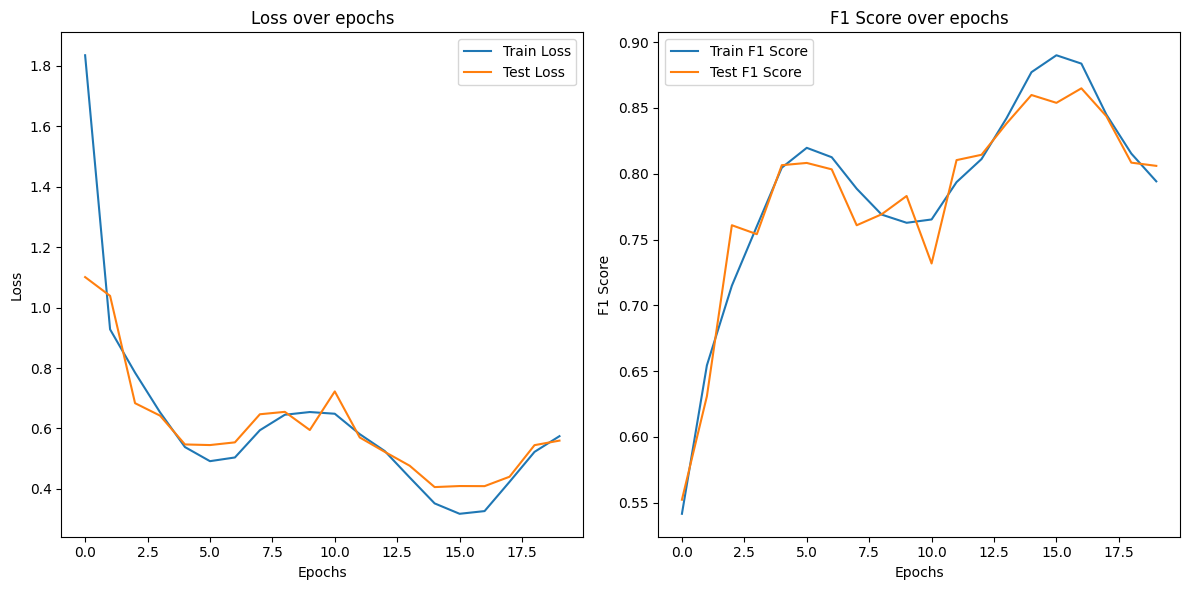

In [ ]:
# Plotting the metrics
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(loss_train, label='Train Loss')
plt.plot(loss_test, label='Test Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(f1_train, label='Train F1 Score')
plt.plot(f1_test, label='Test F1 Score')
plt.title('F1 Score over epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

## 4. Evaluation Model

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import seaborn as sns


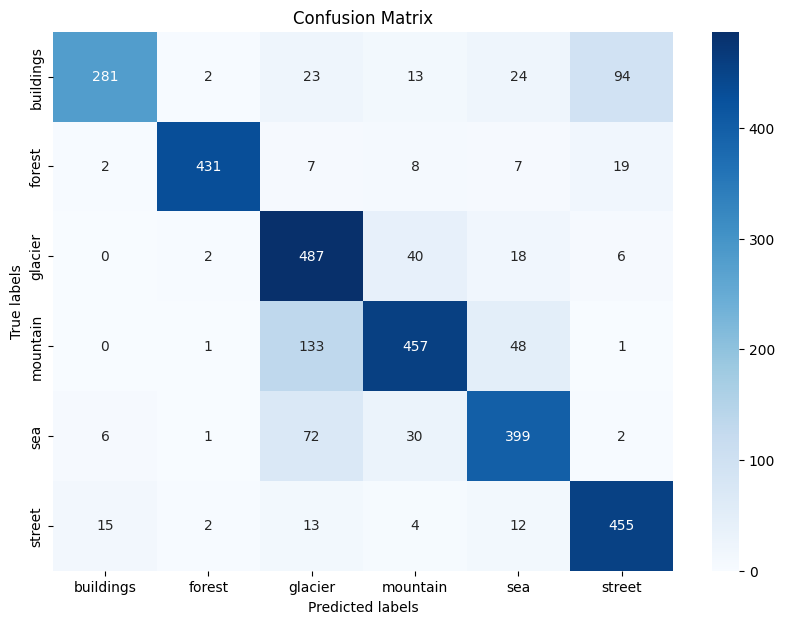

In [ ]:
model.eval()
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for data in TESTLOADER:
        inputs, labels = data
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().tolist())
        all_true_labels.extend(labels.cpu().tolist())


# Compute confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes_name, yticklabels=classes_name)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
f1 = f1_score(all_true_labels, all_predictions, average='weighted')
print("Weighted F1 Score:", f1)

Weighted F1 Score: 0.8059670486134015


In [ ]:
print(classification_report(all_true_labels, all_predictions, target_names=classes_name))

              precision    recall  f1-score   support

   buildings       0.92      0.64      0.76       437
      forest       0.98      0.91      0.94       474
     glacier       0.66      0.88      0.76       553
    mountain       0.83      0.71      0.77       640
         sea       0.79      0.78      0.78       510
      street       0.79      0.91      0.84       501

    accuracy                           0.81      3115
   macro avg       0.83      0.81      0.81      3115
weighted avg       0.82      0.81      0.81      3115



## 5. Practices
Hãy thử làm mọi cách để f1_score trên tập test đạt >= 85%
- Thử thay bằng model có độ phức tạp hơn ( Có dropout, Batch_Norm )
- Dùng optimizer khác, scheduler khác
- Thử tăng hoặc giảm Learning rate, Batch_size
- Thử dùng [Lion Optimizer](https://github.com/lucidrains/lion-pytorch)
```python
!pip install lion-pytorch
from lion_pytorch import Lion
opt = Lion(model.parameters(), lr=1e-4, weight_decay=1e-2)
```



- Question: ý nghĩa của lớp **AdaptiveAvgPool2d**

https://pytorch.org/docs/stable/nn.html